In [215]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 

In [216]:
ROOT_DIR = os.path.dirname(os.getcwd())
DATA_DIR = os.path.join(ROOT_DIR, "data")

In [217]:
base_symbol = "BTC"
quote_symbol = "DOGE"
timeframe = "1m"

base_raw_df = pd.read_csv(
    os.path.join(DATA_DIR, f"{timeframe}_Data", f"{base_symbol}_USDT_{timeframe}.csv"),
    parse_dates=['timestamp']
)
quote_raw_df = pd.read_csv(
    os.path.join(DATA_DIR, f"{timeframe}_Data", f"{quote_symbol}_USDT_{timeframe}.csv"),
    parse_dates=['timestamp']
)

base_close  = base_raw_df['close']
quote_close = quote_raw_df['close']

In [218]:
base_close_series = base_close
quote_close_series = quote_close

shared_timestamps = base_close_series.index.intersection(quote_close_series.index)

base_price_aligned = base_close_series.loc[shared_timestamps]
quote_price_aligned = quote_close_series.loc[shared_timestamps]

base_column = base_price_aligned.to_numpy()
quote_column = quote_price_aligned.to_numpy()

<function matplotlib.pyplot.show(close=None, block=None)>

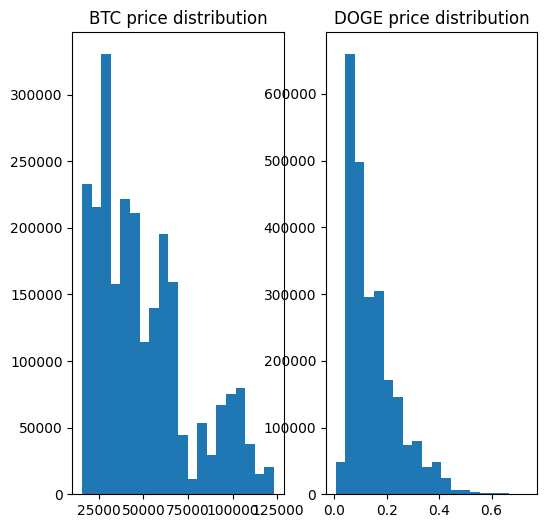

In [219]:
bins = 20

fig,(base_hist,quote_hist) = plt.subplots(nrows=1,ncols=2,figsize=(6,6))
base_hist.hist(base_column,bins=bins)
base_hist.set_title(f"{base_symbol} price distribution")

quote_hist.hist(quote_column,bins=bins)
quote_hist.set_title(f"{quote_symbol} price distribution")

plt.show

In [220]:
price_matrix = np.column_stack(
    [base_column,quote_column]
    )

price_centered_matrix = price_matrix - price_matrix.mean(axis=0)

In [221]:
U,Singular_Vals,V_Trans = np.linalg.svd(price_centered_matrix,full_matrices=False)
principal_vector_one = V_Trans[0]
principal_vector_two = V_Trans[1]
residual_vector = price_centered_matrix @ principal_vector_two

In [222]:
eigenvalues_from_svd = (Singular_Vals**2) / (price_centered_matrix.shape[0] - 1)

In [225]:
base_raw_df['timestamp'] = pd.to_datetime(base_raw_df['timestamp'])
quote_raw_df['timestamp'] = pd.to_datetime(quote_raw_df['timestamp'])

base_raw_df = base_raw_df[['timestamp','close']].rename(columns={"close": "close_base_price"})
quote_raw_df = quote_raw_df[['timestamp','close']].rename(columns={"close":"close_quote_price"})

merged_df = pd.merge(base_raw_df,quote_raw_df,on='timestamp',how='inner')

In [226]:
window = int(0.10 * price_centered_matrix.shape[0])
min_window = int(0.05 * price_centered_matrix.shape[0])

In [227]:
spreads = abs(merged_df['close_base_price'].values - merged_df['close_quote_price'].values)

mean_spreads = pd.Series(spreads).rolling(window=window, min_periods=min_window).mean()
rolling_std  = pd.Series(spreads).rolling(window=window, min_periods=min_window).std().values

z_scores = (spreads - mean_spreads) / rolling_std

merged_df['spread'] = spreads
merged_df['mean_spreads'] = mean_spreads
merged_df['z_score'] = z_scores

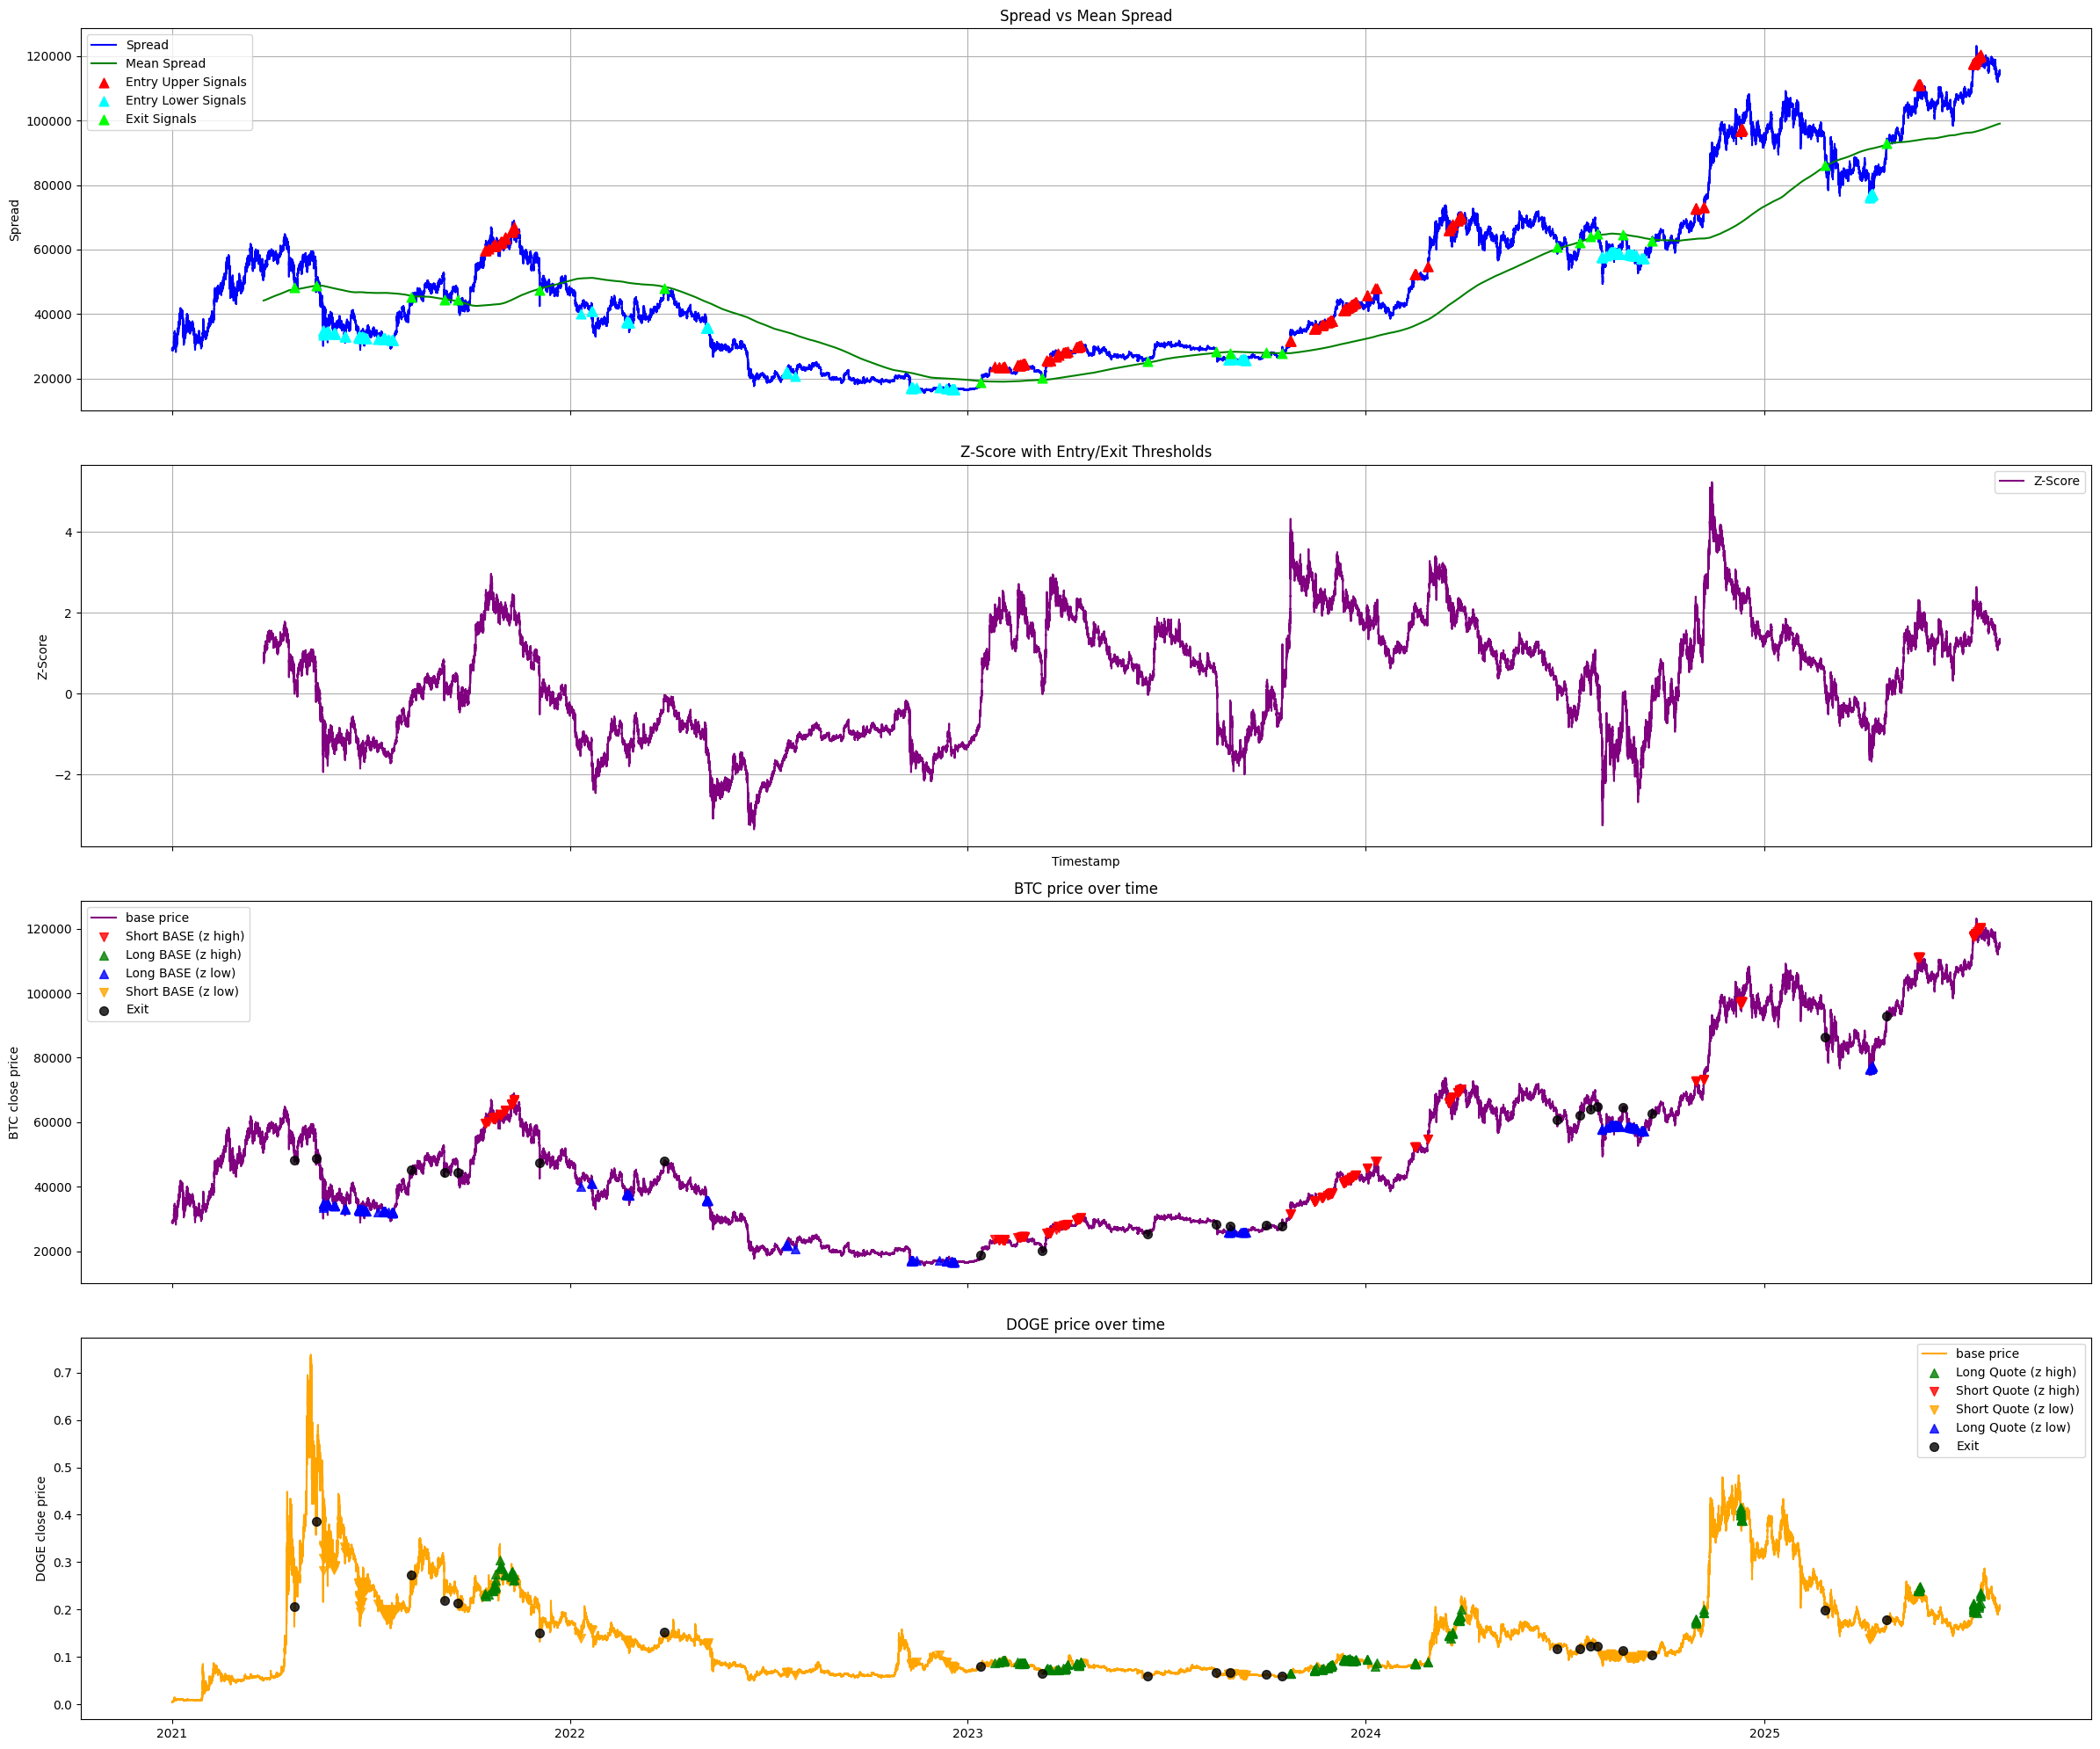

In [228]:
# ==============================
# Figure & Axes
# ==============================
fig, (ax1, ax2, ax3, ax4) = plt.subplots(
    nrows=4, ncols=1, figsize=(24, 20), sharex=True
)

# ==============================
# Thresholds & Signals 
# ==============================
z_scores = z_scores[~np.isnan(z_scores)]
z_scores = np.array(z_scores)

sorted_z_score = np.sort(z_scores)
perc_threshold = 0.10
threshold = int(len(sorted_z_score) * perc_threshold)

upper_tail = sorted_z_score[-threshold:]
lower_tail = sorted_z_score[:threshold]

upper_bound = upper_tail.min()
lower_bound = lower_tail.max()

epsilon = 0.01 * mean_spreads.mean()

# ==============================
# Entry Conditions 
# ==============================
lookback_confirm = 3
upper_condition = merged_df['z_score'] > upper_bound
lower_condition = merged_df['z_score'] < lower_bound

entry_upper_mask = (
    upper_condition.rolling(lookback_confirm, min_periods=lookback_confirm)
    .sum()
    .eq(lookback_confirm)
)
entry_lower_mask = (
    lower_condition.rolling(lookback_confirm, min_periods=lookback_confirm)
    .sum()
    .eq(lookback_confirm)
)

# ==============================
# Candidates from masks
# ==============================
upper_candidates = merged_df.loc[entry_upper_mask]
lower_candidates = merged_df.loc[entry_lower_mask]

# ==============================
# Cooldown filter (Entries)
# ==============================
min_signal_gap = pd.Timedelta("5m")

upper_keep = (
    upper_candidates['timestamp']
    .diff()
    .gt(min_signal_gap)
    .fillna(True)
)
lower_keep = (
    lower_candidates['timestamp']
    .diff()
    .gt(min_signal_gap)
    .fillna(True)
)

entry_upper = upper_candidates.loc[upper_keep]
entry_lower = lower_candidates.loc[lower_keep]

# ==============================
# Exit Signals + Cooldown
# ==============================
exit_signal_gap = pd.Timedelta("5d")
exit_signals = merged_df[
    (merged_df['spread'] - merged_df['mean_spreads']).abs() < epsilon
]

exit_signals = exit_signals[
    exit_signals['timestamp'].diff().fillna(pd.Timedelta("999D")) > exit_signal_gap
]

# ==============================
# Top Plot: Spread + Mean Spread
# ==============================
ax1.plot(merged_df['timestamp'], merged_df['spread'],        label='Spread',      color='blue')
ax1.plot(merged_df['timestamp'], merged_df['mean_spreads'],  label='Mean Spread', color='green')
ax1.set_ylabel("Spread")
ax1.set_title("Spread vs Mean Spread")
ax1.legend()
ax1.grid(True)

# ---------------------------------
# Plot Entry/Exit markers on Spread
# ---------------------------------
ax1.scatter(entry_upper['timestamp'], entry_upper['spread'],
            color='red', marker="^", label='Entry Upper Signals', s=60, zorder=10)
ax1.scatter(entry_lower['timestamp'], entry_lower['spread'],
            color='cyan', marker="^", label='Entry Lower Signals', s=60, zorder=10)
ax1.scatter(exit_signals['timestamp'], exit_signals['spread'],
            color='lime', marker="^", label='Exit Signals', s=60, zorder=10)
ax1.legend()

# ==========================================
# Z-Score Plot: Z + (Entry/Exit) Thresholds
# ==========================================
ax2.plot(merged_df['timestamp'], merged_df['z_score'], label='Z-Score', color='purple')
ax2.set_ylabel("Z-Score")
ax2.set_title("Z-Score with Entry/Exit Thresholds")
ax2.legend()
ax2.grid(True)

# X-axis formatting (shared)
ax2.set_xlabel("Timestamp")
plt.setp(ax2.get_xticklabels(), rotation=45)


# ==================================
# Price Plot: Base (third subplot)
# ==================================
ax3.plot(merged_df['timestamp'], merged_df['close_base_price'],
         label='base price', color='purple')
ax3.set_title(f"{base_symbol} price over time")
ax3.set_ylabel(f"{base_symbol} close price")

# --- Entry Upper (z >>) logic ---
# BASE > QUOTE  -> short BASE, long QUOTE
mask_short_base_long_quote_upper = entry_upper['close_base_price'] > entry_upper['close_quote_price']
# BASE < QUOTE  -> short QUOTE, long BASE
mask_short_quote_long_base_upper = entry_upper['close_base_price'] < entry_upper['close_quote_price']

ax3.scatter(entry_upper['timestamp'][mask_short_base_long_quote_upper],
            entry_upper['close_base_price'][mask_short_base_long_quote_upper],
            marker='v', s=50, alpha=0.8, color='red',   label='Short BASE (z high)', zorder=10)
ax3.scatter(entry_upper['timestamp'][mask_short_quote_long_base_upper],
            entry_upper['close_base_price'][mask_short_quote_long_base_upper],
            marker='^', s=50, alpha=0.8, color='green', label='Long BASE (z high)',  zorder=10)

# --- Entry Lower (z <<) logic ---
# BASE > QUOTE  -> long BASE, short QUOTE
mask_long_base_short_quote_lower = entry_lower['close_base_price'] > entry_lower['close_quote_price']
# BASE < QUOTE  -> long QUOTE, short BASE
mask_long_quote_short_base_lower = entry_lower['close_base_price'] < entry_lower['close_quote_price']

ax3.scatter(entry_lower['timestamp'][mask_long_base_short_quote_lower],
            entry_lower['close_base_price'][mask_long_base_short_quote_lower],
            marker='^', s=50, alpha=0.8, color='blue',  label='Long BASE (z low)',  zorder=10)
ax3.scatter(entry_lower['timestamp'][mask_long_quote_short_base_lower],
            entry_lower['close_base_price'][mask_long_quote_short_base_lower],
            marker='v', s=50, alpha=0.8, color='orange',label='Short BASE (z low)', zorder=10)

# --- Exit markers on BASE ---
ax3.scatter(exit_signals['timestamp'], exit_signals['close_base_price'],
            marker='o', s=50, alpha=0.8, color='black', label='Exit', zorder=12)

ax3.legend(loc='best')

# ===================================
# Price Plot: Quote (fourth subplot)
# ===================================
ax4.plot(merged_df['timestamp'], merged_df['close_quote_price'],
         label='base price', color='orange')
ax4.set_title(f"{quote_symbol} price over time")
ax4.set_ylabel(f"{quote_symbol} close price")

# --- Entry Upper (z >>) markers on QUOTE ---
ax4.scatter(entry_upper['timestamp'][mask_short_base_long_quote_upper],
            entry_upper['close_quote_price'][mask_short_base_long_quote_upper],
            marker='^', s=50, alpha=0.8, color='green', label='Long Quote (z high)',  zorder=10)
ax4.scatter(entry_upper['timestamp'][mask_short_quote_long_base_upper],
            entry_upper['close_quote_price'][mask_short_quote_long_base_upper],
            marker='v', s=50, alpha=0.8, color='red',   label='Short Quote (z high)', zorder=10)

# --- Entry Lower (z <<) markers on QUOTE ---
ax4.scatter(entry_lower['timestamp'][mask_long_base_short_quote_lower],
            entry_lower['close_quote_price'][mask_long_base_short_quote_lower],
            marker='v', s=50, alpha=0.8, color='orange',label='Short Quote (z low)', zorder=10)
ax4.scatter(entry_lower['timestamp'][mask_long_quote_short_base_lower],
            entry_lower['close_quote_price'][mask_long_quote_short_base_lower],
            marker='^', s=50, alpha=0.8, color='blue',  label='Long Quote (z low)',  zorder=10)

# --- Exit markers on QUOTE ---
ax4.scatter(exit_signals['timestamp'], exit_signals['close_quote_price'],
            marker='o', s=50, alpha=0.8, color='black', label='Exit', zorder=12)

ax4.legend(loc='best')


plt.tight_layout()
plt.show()

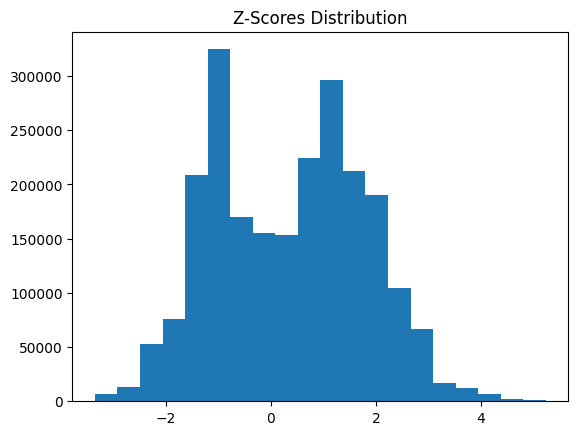

In [229]:
# Z-Scores Distribution
bins = 20

fig,(base_hist) = plt.subplots()
base_hist.hist(z_scores,bins=bins)
base_hist.set_title(f"Z-Scores Distribution")

plt.show()